In [1]:
%load_ext autoreload
%autoreload 2


# Deep Learning Analysis

In [2]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [3]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data_large.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

In [4]:
cdm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, scale_targets=True)
cdm.setup()
target_scaler = cdm.target_scaler

In [5]:
import random


class NNRegressor(L.LightningModule):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU, optimizer=torch.optim.Adam, lr=1e-3, weight_decay=1e-4, target_scaler=None):
        super(NNRegressor, self).__init__()
        self.target_scaler = target_scaler
        self.optimizer = optimizer
        self.lr = lr
        self.weight_decay = weight_decay
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

        self.loss_metric = MeanSquaredError()
        self.val_metric = MeanSquaredError()
        self.test_metric = MeanSquaredError()



    def forward(self, x):
        y = self.network(x)
        return y
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_mse", self.loss_metric(y_hat, y), prog_bar=True)

        return loss
    
    def on_training_epoch_end(self):
        self.log("train_mse", self.loss_metric.compute())
        self.loss_metric.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_mse", self.val_metric(y_hat, y), prog_bar=True)

    def on_validation_epoch_end(self):
        self.log("val_mse", self.val_metric.compute())
        self.val_metric.reset()
        
    def configure_optimizers(self):
        return self.optimizer(self.network.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_mse", self.test_metric(y_hat, y), prog_bar=True)
        return loss
    
    def on_test_epoch_end(self):
        self.log("test_mse", self.test_metric.compute())
        self.test_metric.reset()

simple_nn = NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8,
    target_scaler=target_scaler,
)

In [6]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8,
    target_scaler=target_scaler,
), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
NNRegressor                              [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 1978]                 1,958,220
│    └─BatchNorm1d: 2-2                  [1, 1978]                 3,956
│    └─LeakyReLU: 2-3                    [1, 1978]                 --
│    └─Dropout: 2-4                      [1, 1978]                 --
│    └─Linear: 2-5                       [1, 3956]                 7,828,924
│    └─BatchNorm1d: 2-6                  [1, 3956]                 7,912
│    └─LeakyReLU: 2-7                    [1, 3956]                 --
│    └─Dropout: 2-8                      [1, 3956]                 --
│    └─Linear: 2-9                       [1, 7912]                 31,307,784
│    └─BatchNorm1d: 2-10                 [1, 7912]                 15,824
│    └─LeakyReLU: 2-11                   [1, 7912]   

In [7]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=2,
    target_scaler=target_scaler,
)
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 3.9 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.689    Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [8]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.467365026473999     │
│         test_mse          │     2.467365026473999     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.467365026473999, 'test_mse': 2.467365026473999}]

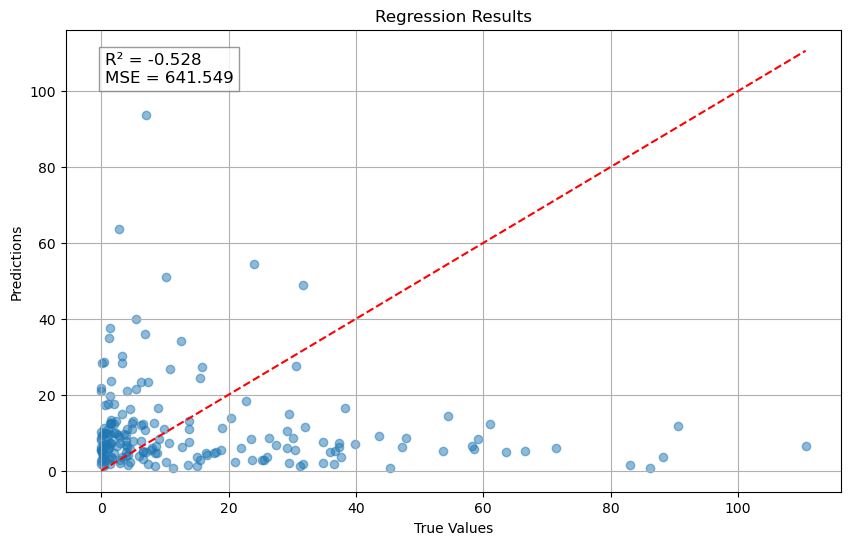

In [17]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


def plot_regression_results(model, dataloader, title="Regression Results"):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = torch.tensor(model.target_scaler.inverse_transform(model(x).numpy()))
            y_true.append(torch.tensor(model.target_scaler.inverse_transform(y.numpy())))
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.grid(True)
    # Add R² and MSE text in upper left corner
    plt.text(
        0.05, 0.95,
        f'R² = {r2:.3f}\nMSE = {mse:.3f}',
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
    )
    plt.show()
plot_regression_results(cancer_regressor, cdm.test_dataloader())

In [10]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model =NNRegressor(
        input_dim=len(cancer_dm.ds_train[0][0]),
        n_layers=n_layers,
        dropout=dropout,
        activation=activation,
        optimizer=optimizer,
        lr=learning_rate,
        weight_decay=weight_decay,
        target_scaler=target_scaler,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"nn_trial_{trial.number}", max_epochs=50, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [11]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="deep_regressor_scaled_study")
study.optimize(objective, n_trials=20, n_jobs=1, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-18 14:35:57,880] A new study created in memory with name: deep_regressor_scaled_study


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 4.4 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.648    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 14:37:29,924] Trial 0 finished with value: 3.201751470565796 and parameters: {'n_layers': 3, 'dropout': 0.1410791329846784, 'learning_rate': 0.0005810194406838969, 'weight_decay': 0.0007773813144894222, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 0 with value: 3.201751470565796.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 4.4 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.648    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:37:54,406] Trial 1 finished with value: 2.363908290863037 and parameters: {'n_layers': 3, 'dropout': 0.12965718234308304, 'learning_rate': 0.00015943739587939484, 'weight_decay': 0.0011320751172753745, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 1 with value: 2.363908290863037.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:38:25,997] Trial 2 finished with value: 1.96914803981781 and parameters: {'n_layers': 5, 'dropout': 0.27310586398957265, 'learning_rate': 0.00866509996385969, 'weight_decay': 0.007463672272531781, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 4.4 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.648    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:39:16,525] Trial 3 finished with value: 3.243101119995117 and parameters: {'n_layers': 3, 'dropout': 0.4846770426270832, 'learning_rate': 6.320980968615257e-05, 'weight_decay': 6.840609527232511e-05, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 14:39:31,682] Trial 4 finished with value: 2.181360483169556 and parameters: {'n_layers': 4, 'dropout': 0.08914078118648061, 'learning_rate': 0.009797485657100667, 'weight_decay': 0.0006008903760299064, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 2 with value: 1.96914803981781.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 4.4 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.648    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:40:04,760] Trial 5 finished with value: 2.396962881088257 and parameters: {'n_layers': 3, 'dropout': 0.12668841652394447, 'learning_rate': 0.009423786449981892, 'weight_decay': 1.588516274207794e-05, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:41:05,829] Trial 6 finished with value: 2.324326753616333 and parameters: {'n_layers': 4, 'dropout': 0.14025734291843245, 'learning_rate': 3.89010454971428e-05, 'weight_decay': 0.00027432172925576803, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


[I 2025-04-18 14:41:20,644] Trial 7 finished with value: 2.474098920822144 and parameters: {'n_layers': 5, 'dropout': 0.29002298442159996, 'learning_rate': 0.004152822359019045, 'weight_decay': 0.0048640564007354364, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 2 with value: 1.96914803981781.


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 14:42:29,791] Trial 8 finished with value: 2.964197397232056 and parameters: {'n_layers': 4, 'dropout': 0.4035132238300894, 'learning_rate': 0.00017025413667530234, 'weight_decay': 0.005232792089662108, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 2 with value: 1.96914803981781.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:43:51,804] Trial 9 finished with value: 4.596478462219238 and parameters: {'n_layers': 4, 'dropout': 0.2678647323951826, 'learning_rate': 0.0002801192871035779, 'weight_decay': 0.004734145349084203, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:46:06,582] Trial 10 finished with value: 3.630859136581421 and parameters: {'n_layers': 5, 'dropout': 0.3573863884306894, 'learning_rate': 1.0368823803261086e-05, 'weight_decay': 0.00014700312269062265, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:46:25,405] Trial 11 finished with value: 2.2943685054779053 and parameters: {'n_layers': 5, 'dropout': 0.005438587199465605, 'learning_rate': 0.0018783183673785006, 'weight_decay': 0.001228481701945606, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:46:46,040] Trial 12 finished with value: 3.045719861984253 and parameters: {'n_layers': 5, 'dropout': 0.015762254147138027, 'learning_rate': 0.0014649015268702655, 'weight_decay': 0.0019133883664264402, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:47:12,997] Trial 13 finished with value: 2.6011643409729004 and parameters: {'n_layers': 4, 'dropout': 0.21268944669135254, 'learning_rate': 0.008537914210953618, 'weight_decay': 6.0909760741961934e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:47:33,310] Trial 14 finished with value: 2.1289587020874023 and parameters: {'n_layers': 4, 'dropout': 0.2081704532699492, 'learning_rate': 0.002377442659597728, 'weight_decay': 0.00949430618447304, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:47:50,235] Trial 15 finished with value: 2.381338834762573 and parameters: {'n_layers': 5, 'dropout': 0.3300815817771351, 'learning_rate': 0.0020761396460568966, 'weight_decay': 0.008341402651687618, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:48:28,824] Trial 16 finished with value: 2.254164934158325 and parameters: {'n_layers': 4, 'dropout': 0.21335772697818955, 'learning_rate': 0.0007917507346993781, 'weight_decay': 0.009934424050327625, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 2 with value: 1.96914803981781.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:48:52,113] Trial 17 finished with value: 1.855353593826294 and parameters: {'n_layers': 4, 'dropout': 0.2123291593035481, 'learning_rate': 0.0039120813050274325, 'weight_decay': 0.0022022163161793773, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 17 with value: 1.855353593826294.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:49:16,481] Trial 18 finished with value: 2.07513689994812 and parameters: {'n_layers': 5, 'dropout': 0.4212755097791299, 'learning_rate': 0.003881510039322354, 'weight_decay': 0.0023882063682385177, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 17 with value: 1.855353593826294.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:49:36,494] Trial 19 finished with value: 2.272340774536133 and parameters: {'n_layers': 5, 'dropout': 0.30749951641804807, 'learning_rate': 0.004479772544278009, 'weight_decay': 0.002325688761733884, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 17 with value: 1.855353593826294.
Best trial:
  Value (val_mse): 1.855353593826294
  Params:
    n_layers: 4
    dropout: 0.2123291593035481
    learning_rate: 0.0039120813050274325
    weight_decay: 0.0022022163161793773
    optimizer: adam
    activation: RReLU


In [19]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

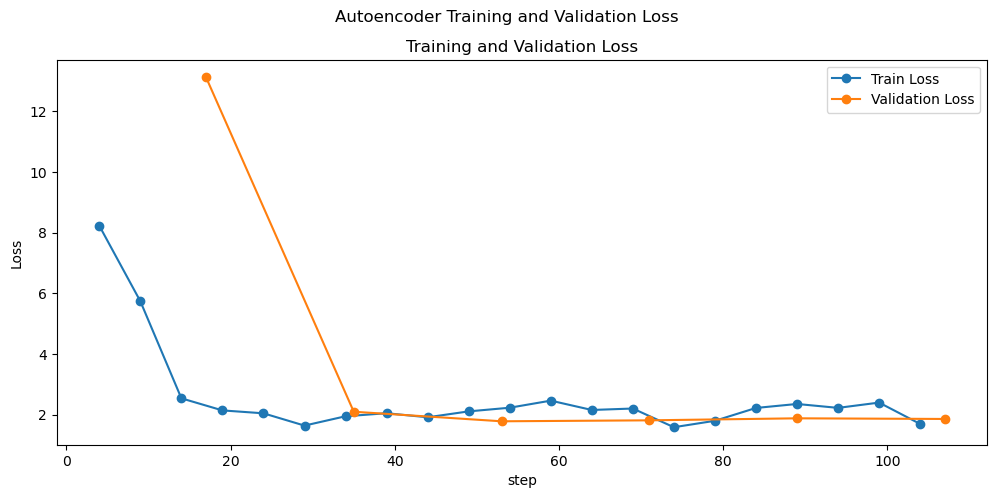

: 

In [ ]:
from utils.helper_functions import make_plots


history = pd.read_csv(best_model_logger.log_dir + "/metrics.csv")
make_plots(history, "Autoencoder Training and Validation Loss")

In [12]:
activation_dict = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
    "tanh": nn.Tanh,
    "RReLU": nn.RReLU,
}
optimizer_dict = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adagrad": torch.optim.Adagrad,
}
best_model = model =NNRegressor(
        input_dim=len(cancer_dm.ds_train[0][0]),
        n_layers=study.best_trial.params["n_layers"],
        dropout=study.best_trial.params["dropout"],
        activation=activation_dict[study.best_trial.params["activation"]],
        optimizer=optimizer_dict[study.best_trial.params["optimizer"]],
        lr=study.best_trial.params["learning_rate"],
        weight_decay=study.best_trial.params["weight_decay"],
        target_scaler=target_scaler,
    )

In [13]:
joblib.dump(
    best_model,
    f"results/06/best_model_trial_noae_{study.best_trial.number}.pkl",
)

['results/06/best_model_trial_noae_17.pkl']

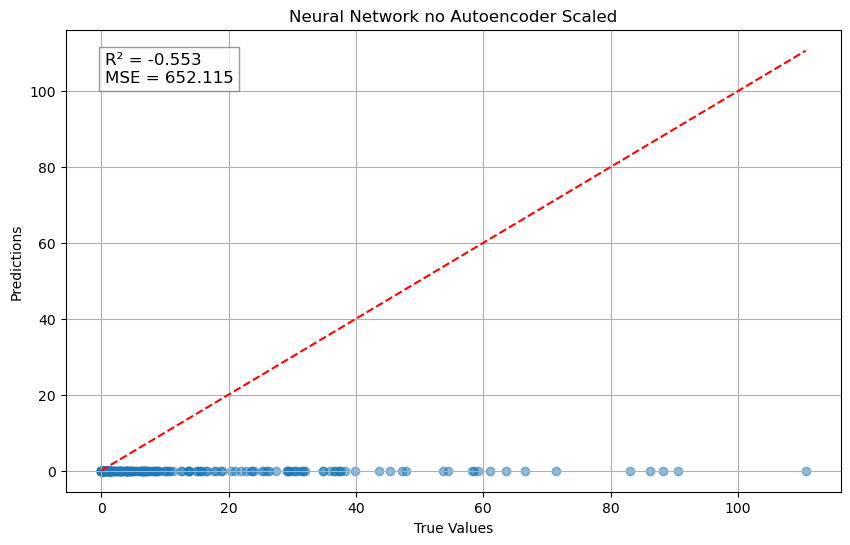

In [18]:
plot_regression_results(best_model, cdm.test_dataloader(),  title="Neural Network no Autoencoder Scaled")